In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import time
from torch.utils.data import DataLoader, Dataset
import random
from sklearn.model_selection import train_test_split
import torch.optim as optim
import subprocess

In [2]:
Annotation_Data = pd.read_csv("Annotation_Classifier.csv")
Sequence_Data = pd.read_csv("Sequence_Classifier_Data.csv")
Structure_Data = pd.read_csv("Structure_Classifier.csv")

In [3]:
Combined_Data = pd.read_csv("Combined_Data.csv")

In [4]:
Sequence_Data["UniProtID"] = Combined_Data["UniProtID"].tolist()

In [29]:
Sequence_Data.to_csv("Sequence_Classifier_Fixed.csv", index=False)

In [5]:
Annotation_Sequence = Annotation_Data.merge(Sequence_Data, how = "inner", on = "UniProtID")
Full_Data = Annotation_Sequence.merge(Structure_Data, how = "inner", on = "UniProtID")

In [6]:
Full_Data.head()


,UniProtID,Pred_EC_x,Weights_x,EC_x,Weights_y,Pred_EC_y,EC_y,Pred_EC,Weights,EC
0,A0AVI4,EC 2.3.2.27,"[-5.5739336013793945, -5.084689617156982, -2.1...",EC 2.3.2.27,"[-6.27648401260376, -6.906259536743164, -3.747...",EC 2.3.2.27,EC 2.3.2.27,EC 2.3.2.27,"[0.05799338221549988, -2.5418972969055176, -3....",EC 2.3.2.27
1,A0AVT1,EC 6.2.1.45,"[-3.821723461151123, -3.7421019077301025, -3.2...",EC 6.2.1.45,"[-3.9260072708129883, -3.4674453735351562, -0....",EC 6.2.1.45,EC 6.2.1.45,EC 3.6.4.13,"[-0.9200097322463989, -0.4853212833404541, -1....",EC 6.2.1.45
2,A0PJZ3,EC 2.4.2.42,"[-1.7508244514465332, 0.9232233166694641, -2.2...",EC 2.4.2.42,"[11.505988121032715, 7.015631198883057, 2.4812...",EC 2.4.2.42,EC 2.4.2.42,EC 2.7.11.1,"[0.2165713757276535, -2.7592759132385254, -3.4...",EC 2.4.2.42
3,A1L167,EC 2.3.2.23,"[-3.5674166679382324, -2.211075782775879, -1.8...",EC 2.3.2.23,"[-11.840338706970215, -10.450056076049805, -6....",EC 2.3.2.23,EC 2.3.2.23,EC 2.3.2.23,"[0.6983829736709595, -2.8269362449645996, -2.5...",EC 2.3.2.23
4,A1L3X0,EC 2.3.1.199,"[2.842302083969116, 2.413073778152466, -3.2969...",EC 2.3.1.199,"[-7.445174694061279, -9.31412410736084, -5.131...",EC 2.3.1.199,EC 2.3.1.199,EC 2.3.1.199,"[-0.4906758964061737, -2.652627468109131, -2.8...",EC 2.3.1.199


In [7]:
#drop extra columns
Full_Data = Full_Data.drop(columns=["Pred_EC_x", "EC_x", "Pred_EC_y", "EC_y","Pred_EC"], axis=1)
Full_Data.head()

,UniProtID,Weights_x,Weights_y,Weights,EC
0,A0AVI4,"[-5.5739336013793945, -5.084689617156982, -2.1...","[-6.27648401260376, -6.906259536743164, -3.747...","[0.05799338221549988, -2.5418972969055176, -3....",EC 2.3.2.27
1,A0AVT1,"[-3.821723461151123, -3.7421019077301025, -3.2...","[-3.9260072708129883, -3.4674453735351562, -0....","[-0.9200097322463989, -0.4853212833404541, -1....",EC 6.2.1.45
2,A0PJZ3,"[-1.7508244514465332, 0.9232233166694641, -2.2...","[11.505988121032715, 7.015631198883057, 2.4812...","[0.2165713757276535, -2.7592759132385254, -3.4...",EC 2.4.2.42
3,A1L167,"[-3.5674166679382324, -2.211075782775879, -1.8...","[-11.840338706970215, -10.450056076049805, -6....","[0.6983829736709595, -2.8269362449645996, -2.5...",EC 2.3.2.23
4,A1L3X0,"[2.842302083969116, 2.413073778152466, -3.2969...","[-7.445174694061279, -9.31412410736084, -5.131...","[-0.4906758964061737, -2.652627468109131, -2.8...",EC 2.3.1.199


In [8]:
#rename remaining columns appropriately
Full_Data.columns = ["UniProtID", "Annotation_Weights", "Sequence_Weights", "Structure_Weights", "EC"]

In [9]:
def convert_weights_to_numeric(df_col):
    numeric_weights = []
    for i in range(len(df_col)):
        tokens = df_col[i]
        tokens = tokens[1:]
        tokens = tokens[:-1]
        tokens_list = tokens.split(",")
        tokens_list_fixed = [x[1:] for x in tokens_list if x[0] == " "]
        numeric_tokens_list = [float(x) for x in tokens_list_fixed]
        numeric_weights.append(torch.tensor(numeric_tokens_list, dtype=torch.float32))
    return(numeric_weights)

In [10]:
class EnsembleDataset(Dataset):
    def __init__(self, Full_Df):
        super().__init__()
        self.ID = Full_Df["UniProtID"].tolist()
        self.labels = [EC2idx.get(ec, -1) for ec in Full_Df["EC"]]
        self.ann_weights = convert_weights_to_numeric(Full_Df["Annotation_Weights"])
        self.seq_weights = convert_weights_to_numeric(Full_Df["Sequence_Weights"])
        self.struct_weights = convert_weights_to_numeric(Full_Df["Structure_Weights"])

    def __len__(self):
        return len(self.ID)

    def __getitem__(self, index):
        ann_weight = self.ann_weights[index]
        seq_weight = self.seq_weights[index]
        struct_weight = self.struct_weights[index]
        label = torch.tensor(self.labels[index], dtype=torch.long)
        ID = self.ID[index]
        return ID, ann_weight, seq_weight, struct_weight, label

In [11]:
Train_Data, Test_Data = train_test_split(Full_Data, test_size=0.2, random_state=0)

In [12]:
Train_Data, Val_Data = train_test_split(Train_Data, test_size=0.125, random_state=33)

In [13]:
Train_Data = Train_Data.reset_index()
Val_Data = Val_Data.reset_index()
Test_Data = Test_Data.reset_index()

In [14]:
EC = Full_Data["EC"].tolist()
EC = set(EC)
EC2idx = {ec: idx for idx, ec in enumerate(EC)}

In [15]:
num_classes = len(EC)

In [16]:
print(num_classes)


1333


In [17]:
Train_Dataset = EnsembleDataset(Train_Data)
Val_Dataset = EnsembleDataset(Val_Data)
Test_Dataset = EnsembleDataset(Test_Data)

In [18]:
class MultiHeadAttentionClassifier(nn.Module):
    def __init__(self, embed_dim=4096, num_heads=1024, ff_dim=32, num_classes=1333):
        super(MultiHeadAttentionClassifier, self).__init__()
        self.projection = nn.Linear(1341, embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim, num_heads)
        self.linear_1 = nn.Linear(embed_dim, ff_dim)
        self.dropout_1 = nn.Dropout(0.5)
        self.linear_2 = nn.Linear(ff_dim, embed_dim)
        self.dropout_2 = nn.Dropout(0.5)
        self.norm_1 = nn.LayerNorm(embed_dim)
        self.norm_2 = nn.LayerNorm(embed_dim)
        
        #self.pooling = nn.AdaptiveAvgPool1d(1) 
        self.fc = nn.Linear(embed_dim, num_classes)
    
    def forward(self, x, y, z):
        x = self.projection(x)
        y = self.projection(y)
        z = self.projection(z)
        out2,_ = self.attention(x,y,z)
        out = out2 + self.dropout_1(out2)
        out = self.norm_1(out)
        out2 = self.linear_2(self.dropout_1(F.relu(self.linear_1(out))))
        out = out + self.dropout_2(out2)
        out = self.norm_2(out)   
        #out = self.pooling(out).squeeze(-1)
        return self.fc(out)

In [19]:
def train_model_ensemble(model, train_dataset, val_dataset, num_classes, epochs=100, batch_size=256, lr=1e-3, patience=10, device='cuda:0'):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_acc = 0
    patience_counter = 0
    best_ckpt = None

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for IDs, ann_weights, seq_weights, struct_weights, labels in train_loader:
            # TODO: backpropagation
            #####
            model = model.to(device)
            ann_weights = ann_weights.to(device)
            seq_weights = seq_weights.to(device)
            struct_weights = struct_weights.to(device)
            labels = labels.to(device)
            outputs = model(ann_weights, seq_weights, struct_weights)
            outputs = outputs.to(device)
            loss = criterion(outputs, labels)
             #zero's grad for backprogation
            optimizer.zero_grad()

            #backpropagates
            loss.backward()

            #steps forward
            optimizer.step()
            #####
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for IDs, ann_weights, seq_weights, struct_weights, labels in val_loader:
                # TODO: inference
                #####
                model = model.to(device)
                ann_weights = ann_weights.to(device)
                seq_weights = seq_weights.to(device)
                struct_weights = struct_weights.to(device)
                labels = labels.to(device)
                outputs = model(ann_weights, seq_weights, struct_weights)
                pred = outputs.argmax(dim=1)
                #####
                correct += (pred == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        print(f'Epoch {epoch+1}: Train Loss={total_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}')

        # Early stopping
        if val_acc > best_acc:
            best_acc = val_acc
            best_ckpt = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    return model, best_ckpt, best_acc

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = MultiHeadAttentionClassifier().to(device)
model, best_ckpt,_ = train_model_ensemble(model, Train_Dataset, Val_Dataset, num_classes,epochs=500, batch_size=256, lr=7e-5, patience=100, device=device)
model.load_state_dict(best_ckpt)

Epoch 1: Train Loss=67.7579, Train Acc=0.0650, Val Acc=0.0776
Epoch 2: Train Loss=58.3663, Train Acc=0.1466, Val Acc=0.1745
Epoch 3: Train Loss=50.2638, Train Acc=0.2492, Val Acc=0.2992
Epoch 4: Train Loss=42.3532, Train Acc=0.3423, Val Acc=0.3850
Epoch 5: Train Loss=33.9607, Train Acc=0.4362, Val Acc=0.4266
Epoch 6: Train Loss=26.9376, Train Acc=0.5285, Val Acc=0.4571
Epoch 7: Train Loss=21.2155, Train Acc=0.6197, Val Acc=0.4903
Epoch 8: Train Loss=16.3966, Train Acc=0.7223, Val Acc=0.4875
Epoch 9: Train Loss=12.6252, Train Acc=0.8336, Val Acc=0.5180
Epoch 10: Train Loss=9.4320, Train Acc=0.9105, Val Acc=0.5346
Epoch 11: Train Loss=6.5850, Train Acc=0.9560, Val Acc=0.5512
Epoch 12: Train Loss=4.4892, Train Acc=0.9794, Val Acc=0.5568
Epoch 13: Train Loss=3.3451, Train Acc=0.9818, Val Acc=0.5596
Epoch 14: Train Loss=2.2666, Train Acc=0.9865, Val Acc=0.5679
Epoch 15: Train Loss=1.6113, Train Acc=0.9917, Val Acc=0.5651
Epoch 16: Train Loss=1.2230, Train Acc=0.9937, Val Acc=0.5651
Epoch 17

<All keys matched successfully>

In [169]:
epochs = [200,300,400,500]
patiences = [20,30,40,50]
lrs = [1e-5,7e-5,1e-4,3e-4]
batch_sizes = [32,64,128,256]
best_acc = 0
best_epoch = -100
best_patience = -100
best_lr = -100
best_batch = -100
for epoch in epochs:
    for patience in patiences:
        for lr in lrs:
            for batch_size in batch_sizes:
                model = MultiHeadAttentionClassifier().to(device)
                model, best_ckpt, curr_acc = train_model_ensemble(model, Train_Dataset, Val_Dataset, num_classes,epochs=epoch, batch_size=batch_size, lr=lr, patience=patience, device=device)
                if (curr_acc > best_acc):
                    best_acc = curr_acc
                    best_epoch = epoch
                    best_patience = patience
                    best_lr = lr
                    best_batch = batch_size
                    print(f"Current Best Hyperparameters: Epochs: {epoch}, Patience: {patience}, Learning_Rate: {lr}, Batch_Size: {batch_size} | Current Best Val Accuracy: {best_acc})")

Epoch 1: Train Loss=569.2502, Train Acc=0.0361, Val Acc=0.0693
Epoch 2: Train Loss=546.6445, Train Acc=0.0412, Val Acc=0.0693
Epoch 3: Train Loss=559.9180, Train Acc=0.0353, Val Acc=0.0693
Epoch 4: Train Loss=568.3801, Train Acc=0.0333, Val Acc=0.0471
Epoch 5: Train Loss=555.3138, Train Acc=0.0452, Val Acc=0.0803
Epoch 6: Train Loss=556.4398, Train Acc=0.0432, Val Acc=0.0803
Epoch 7: Train Loss=554.5266, Train Acc=0.0598, Val Acc=0.0831
Epoch 8: Train Loss=539.3775, Train Acc=0.0571, Val Acc=0.0776
Epoch 9: Train Loss=526.5310, Train Acc=0.0788, Val Acc=0.0831
Epoch 10: Train Loss=514.1647, Train Acc=0.0824, Val Acc=0.1163
Epoch 11: Train Loss=493.2365, Train Acc=0.0899, Val Acc=0.1468
Epoch 12: Train Loss=497.6638, Train Acc=0.0943, Val Acc=0.0720
Epoch 13: Train Loss=496.2994, Train Acc=0.0820, Val Acc=0.0970


KeyboardInterrupt: 

In [ ]:
num_heads = [512,1024,2048]
ff_dim = [32,64,128,256]
best_ff = 0
best_heads
best_acc = 0
for head in num_heads:
    for ff in ff_dim:
        model = MultiHeadAttentionClassifier(num_heads=head, ff_dim=ff).to(device)
        model, best_ckpt, curr_acc = train_model_ensemble(model, Train_Dataset, Val_Dataset, num_classes,epochs=300, batch_size=64, lr=7e-4, patience=50, device=device)
        if (curr_acc > best_acc):
                best_acc = curr_acc
                best_ff = ff
                best_heads = head
                print(f"Current Best Hyperparameters: Num_Heads: {head}, ff_dim: {ff} | Current Best Val Accuracy: {best_acc})")
        

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = MultiHeadAttentionClassifier(embed_dim=4096, num_heads=1024, ff_dim=32).to(device)
model, best_ckpt,_ = train_model_ensemble(model, Train_Dataset, Val_Dataset, num_classes,epochs=500, batch_size=256, lr=7e-5, patience=100, device=device)
model.load_state_dict(best_ckpt)

In [197]:
model.eval()
preds = []
test_loader = DataLoader(Test_Dataset, batch_size=64)
ID_List = []
correct, total = 0, 0
weights = []
real_ECs = []
with torch.no_grad():
    for IDs, ann_weights, seq_weights, struct_weights, labels in test_loader:
        model = model.to(device)
        ann_weights = ann_weights.to(device)
        seq_weights = seq_weights.to(device)
        struct_weights = struct_weights.to(device)
        labels = labels.to(device)
        outputs = model(ann_weights, seq_weights, struct_weights)
        pred = outputs.argmax(dim=1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)
        pred = pred.detach().cpu()
        ID_List += IDs
        labels = labels.detach().cpu()
        outputs = outputs.detach().cpu()
        preds += pred.tolist()
        weights += outputs.tolist()
        real_ECs += labels.tolist()
test_acc = correct / total
print(test_acc)

0.5512465373961218


In [198]:
ECs = list(EC2idx.keys())
Idxs = list(EC2idx.values())
Idxs2ECs = dict(zip(Idxs, ECs))

In [199]:
preds = [Idxs2ECs[pred] for pred in preds]

In [200]:
real_EC_not_idx = [Idxs2ECs[x] for x in real_ECs]

In [201]:
df_preds = pd.DataFrame({"UniProtID" : ID_List, "Pred_EC": preds, "Weights" : weights, "EC": real_EC_not_idx})
df_preds.to_csv('Ensemble_Classifier.csv', index=False)

In [203]:
IDs = []
for i in range(Test_Dataset.__len__()):
    ID, _, _, _, _ = Test_Dataset.__getitem__(i)
    IDs.append(ID)
out_str = "\n".join(IDs)
with open("New_Test_IDs.txt", 'w') as file:
    file.write(out_str)

In [21]:
def train_model_ensemble(model, train_dataset, val_dataset, num_classes, epochs=100, batch_size=256, lr=1e-3, patience=10, device='cuda:0'):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    train_losses = []
    val_accs = []
    train_accs = []

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_acc = 0
    patience_counter = 0
    best_ckpt = None

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for IDs, ann_weights, seq_weights, struct_weights, labels in train_loader:
            # TODO: backpropagation
            #####
            model = model.to(device)
            ann_weights = ann_weights.to(device)
            seq_weights = seq_weights.to(device)
            struct_weights = struct_weights.to(device)
            labels = labels.to(device)
            outputs = model(ann_weights, seq_weights, struct_weights)
            outputs = outputs.to(device)
            loss = criterion(outputs, labels)
             #zero's grad for backprogation
            optimizer.zero_grad()

            #backpropagates
            loss.backward()

            #steps forward
            optimizer.step()
            #####
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for IDs, ann_weights, seq_weights, struct_weights, labels in val_loader:
                # TODO: inference
                #####
                model = model.to(device)
                ann_weights = ann_weights.to(device)
                seq_weights = seq_weights.to(device)
                struct_weights = struct_weights.to(device)
                labels = labels.to(device)
                outputs = model(ann_weights, seq_weights, struct_weights)
                pred = outputs.argmax(dim=1)
                #####
                correct += (pred == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        print(f'Epoch {epoch+1}: Train Loss={total_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}')
        train_losses.append(total_loss)
        val_accs.append(val_acc)
        train_accs.append(train_acc)

        # Early stopping
        if val_acc > best_acc:
            best_acc = val_acc
            best_ckpt = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    return model, best_ckpt, best_acc, train_losses, val_accs, train_accs

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = MultiHeadAttentionClassifier(embed_dim=4096, num_heads=1024, ff_dim=32, num_classes=1333).to(device)
_,_,_,train_losses, val_accs, train_accs = train_model_ensemble(model, Train_Dataset, Val_Dataset, num_classes,epochs=500, batch_size=256, lr=7e-5, patience=30, device=device)
model.load_state_dict(best_ckpt)

Epoch 1: Train Loss=63.1281, Train Acc=0.1161, Val Acc=0.1634
Epoch 2: Train Loss=52.0030, Train Acc=0.2235, Val Acc=0.2825
Epoch 3: Train Loss=43.7324, Train Acc=0.3185, Val Acc=0.3601
Epoch 4: Train Loss=35.6635, Train Acc=0.4085, Val Acc=0.4017
Epoch 5: Train Loss=28.3283, Train Acc=0.4925, Val Acc=0.4460
Epoch 6: Train Loss=22.1448, Train Acc=0.5947, Val Acc=0.4820
Epoch 7: Train Loss=17.0729, Train Acc=0.7124, Val Acc=0.5069
Epoch 8: Train Loss=13.0168, Train Acc=0.8288, Val Acc=0.5319
Epoch 9: Train Loss=9.5117, Train Acc=0.9073, Val Acc=0.5512
Epoch 10: Train Loss=6.7884, Train Acc=0.9580, Val Acc=0.5540
Epoch 11: Train Loss=4.7763, Train Acc=0.9723, Val Acc=0.5568
Epoch 12: Train Loss=3.1800, Train Acc=0.9849, Val Acc=0.5706
Epoch 13: Train Loss=2.2835, Train Acc=0.9885, Val Acc=0.5623
Epoch 14: Train Loss=1.5976, Train Acc=0.9917, Val Acc=0.5762
Epoch 15: Train Loss=1.2282, Train Acc=0.9948, Val Acc=0.5734
Epoch 16: Train Loss=0.9510, Train Acc=0.9964, Val Acc=0.5789
Epoch 17:

<All keys matched successfully>

In [23]:
import matplotlib.pyplot as plt

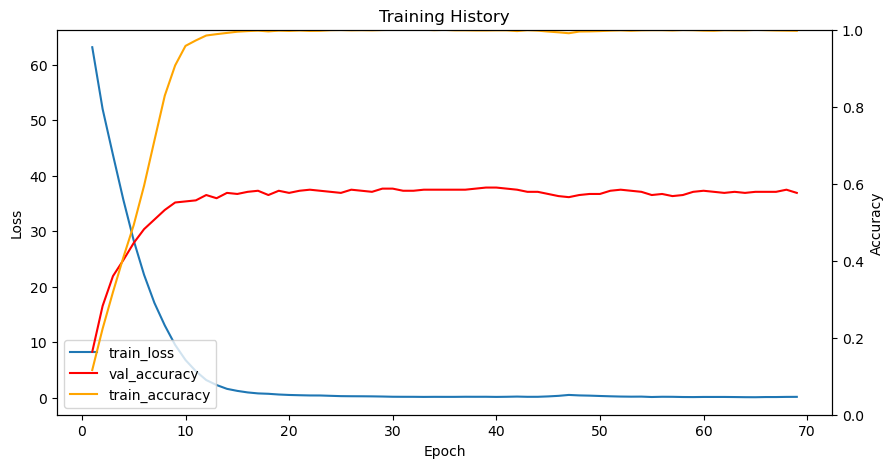

In [27]:
# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

epochs = range(1, 70)

# Plot loss and val_loss on the first y-axis
line1 = ax1.plot(epochs, train_losses, label='train_loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Plot the computed metric on the second y-axis
line2 = ax2.plot(epochs, val_accs, color='red', label='val_accuracy')
line3 = ax2.plot(epochs, train_accs, color='orange', label='train_accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_ylim([0, 1])

# Combine the lines from both y-axes and create a single legend
lines = line1 + line2 + line3
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='lower left')

# Show the plot
plt.title("Training History")
plt.show()